In [1]:
from GT import get_dataset
import matplotlib.pyplot as plt
from GT import GTM
import json
import torch
import numpy as np
import pandas as pd
import os
import seaborn as sns
from Notebooks.Eval.VisualEval import plot_pca


DATASET_NAME = 'Synth'
MODEL_NAME= 'GMM'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [2]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [3]:
# Model Parameters 100 hidden
hidden_size = 64
num_layers = 1
lr = 0.001
weight_decay = 0.001
# weight_decay = 0
dropout = 0.1
bidirectional = True
mixture_dim = 6
train_from_checkpoint = False

## Dataset

In [4]:
# Dataset Split\
Train, Validation, Test = get_dataset('Synth')

# Train[..., 0] = Train[..., 5]

train_data = Train
train_data = torch.Tensor(train_data)
# exo_var = torch.range(0, train_data.shape[0]*train_data.shape[1]-1).reshape(train_data.shape[0], train_data.shape[1], 1)
exo_var = []



input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)
exo_size = 0
# exo_var = (exo_var - exo_var.min()) / (exo_var.max() - exo_var.min())  

Synth DATA
Original Dataset: 	1494
Train Split: 		498 	(70%)
Validation Split: 	498 	(20%)
Test Split: 		498 	(10%)


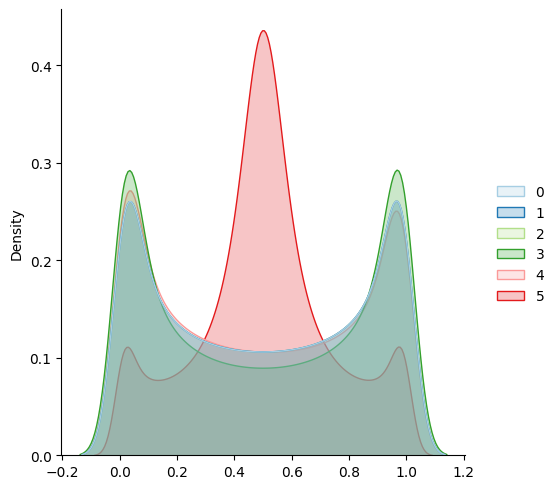

In [5]:
sns.displot(train_data.view(train_data.shape[0]*train_data.shape[1], train_data.shape[2]), fill=True, kind='kde', palette='Paired')
plt.show()

## Model Train

In [6]:
# Model Train
model = GTM(input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, exo_size)

configs = input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, exo_size
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, batch_size=1, window=15, horizon=1, epochs=10)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_8245/1152370375.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unles

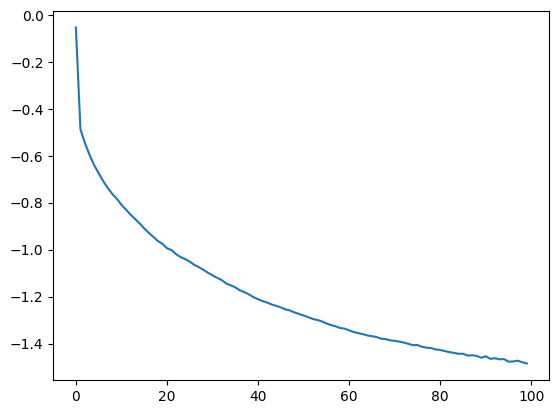

<Figure size 640x480 with 0 Axes>

In [7]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

In [8]:
output = model.generate_step(shape=(1, 63, 6), window = 15, horizon=1)
# prediction = model.predict_step(train_data[0:10], steps=63)
# prediction2 = model.predict_step(torch.tensor(output), steps=63)

100%|██████████| 63/63 [00:00<00:00, 115.38it/s]


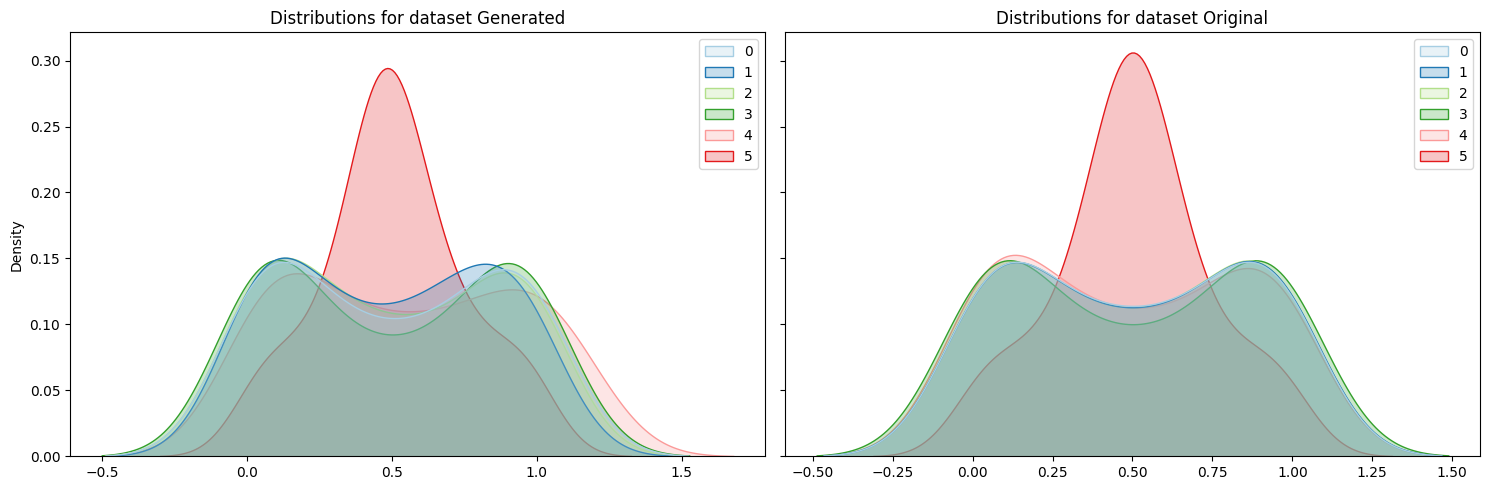

In [9]:
def plot_dist(datasets, kind='kde'):
    # Create a figure with 3 subplots
    fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5), sharey=True, sharex=False)
    if kind == 'box':
        plot_ = sns.boxplot
    elif kind == 'ecdf':
        plot_ = sns.ecdfplot
    elif kind == 'kde':
        plot_ = sns.kdeplot
    else:
        plot_ = sns.histplot

    reshaped_output = {}
    for key, gen in datasets.items():
        # Reshape the data to combine samples and time steps (flatten them)
        reshaped_output[key] = gen.reshape(gen.shape[0] * gen.shape[1], gen.shape[2])
        
    # Plot KDE for each feature (assuming output has 3 features)
    for i, item in zip(range(0, len(reshaped_output)), reshaped_output.items()):
        k, data = item
        if kind == 'kde':
            plot_(data, ax=ax[i], palette='Paired', fill=True)
        else:
            plot_(data, ax=ax[i], palette='Paired')
        ax[i].set_title(f'Distributions for dataset {k}')

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_dist({'Generated': output, 'Original': train_data[0:1]}, 'kde')
# plot_dist({'Generated': output, 'Predicted': prediction, 'Prediction on Gen': prediction2, 'Original': train_data[0:1]}, 'kde')

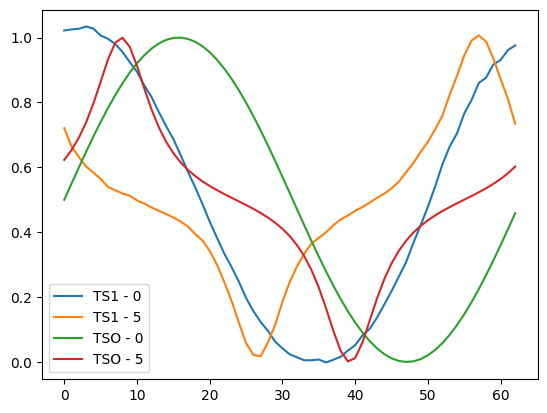

In [10]:
plt.plot(output[0, :, 0], label='TS1 - 0')
# plt.plot(output[0, :, 1], label='TS1 - 1')
# plt.plot(output[0, :, 2], label='TS1 - 2')
# plt.plot(output[0, :, 3], label='TS1 - 3')
# plt.plot(output[0, :, 4], label='TS1 - 4')
plt.plot(output[0, :, 5], label='TS1 - 5')

# plt.plot(output1[0, :, 0], label='TS2 - 0')
# plt.plot(output1[0, :, 1], label='TS2 - 1')
# plt.plot(output1[0, :, 2], label='TS2 - 2')
# plt.plot(output1[0, :, 3], label='TS2 - 3')
# plt.plot(output1[0, :, 4], label='TS2 - 4')
# plt.plot(output1[0, :, 5], label='TS2 - 5') 


# plt.plot(prediction[0, :, 0], label='Pred - 0')
# plt.plot(prediction[0, :, 1], label='Pred - 1')
# plt.plot(prediction[0, :, 2], label='Pred - 2')
# plt.plot(prediction[0, :, 3], label='Pred - 3')
# plt.plot(prediction[0, :, 4], label='Pred - 4')
# plt.plot(prediction[0, :, 5], label='Pred - 5')


plt.plot(train_data[0, :, 0], label='TSO - 0')
# plt.plot(train_data[0, :, 1], label='TSO - 1')
# plt.plot(train_data[0, :, 2], label='TSO - 2')
# plt.plot(train_data[0, :, 3], label='TSO - 3')
# plt.plot(train_data[0, :, 4], label='TSO - 4')
plt.plot(train_data[0, :, 5], label='TSO - 5')
plt.legend()
plt.show()

3


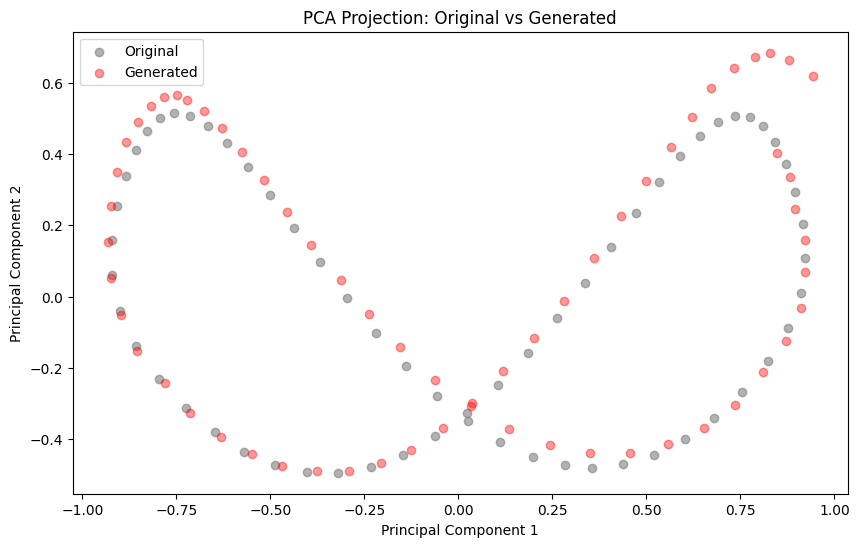

In [11]:
from Notebooks.Eval.VisualEval import plot_pca

# plot_pca(train_data[:1], prediction[:1], component_to_plot=(0, 1))
plot_pca(train_data[:1], output[:1], component_to_plot=(0, 2))